In [26]:
import os
import numpy as np
import pandas as pd
from pandas import concat
import readcsv


USE_all_series =True

if USE_all_series:
    ts = readcsv.get_data(start='2000-01-01', end='2020-12-31', method='ffill',
    normalize=True, init='bfill', txt='file_names.txt', verbose=False)
    no_steps, no_series = ts.shape
    print('number of time steps used is %d , and the number of time-series used is %d' %(no_steps, no_series)    )

else:
    file_USDEUR = 'Data/USDEUR.csv'
    file_USICSAM = 'Data/USICSAM.csv'
    file_EZ_CI = 'Data/Euro Area Consumer Confidence Index.csv'
    file_german9year = 'Bond-Germany9-yearNoteYield(IGDEU9D).csv'

    time_series_USICSAM = pd.read_csv(file_USICSAM, sep=',', header=2, index_col=0, parse_dates=['Date'])
    time_series_USDEUR = pd.read_csv(file_USDEUR, sep=',', header=2, index_col=0, parse_dates=['Date'])
    time_series_EZ_CI = pd.read_csv(file_EZ_CI, sep=',', header=2, index_col=0, parse_dates=['Date'])

    #we have to first pad missing values and then select dates otherwise dimensions don't match due to low frequency
    time_series_USICSAM = time_series_USICSAM['Close'].resample('D').pad()['2001-01-01':'2020-12-31']  
    time_series_USDEUR = time_series_USDEUR['Close'].resample('D').pad()['2001-01-01':'2020-12-31']
    time_series_EZ_CI = time_series_EZ_CI['Close'].resample('D').pad()['2001-01-01':'2020-12-31']


    print(type(time_series_EZ_CI))
    print('Unemployment claims: \n', time_series_USICSAM)
    print('\n Exchange rate: \n', time_series_USDEUR)
    print('\n Eurozone Consumer Index: \n', time_series_EZ_CI)
    
    #concatenate values (i.e. w/o date) of series into a single array
    print(np.shape(time_series_USICSAM.values))
    ts = np.transpose(np.vstack((time_series_USDEUR.values, time_series_USICSAM.values, time_series_EZ_CI.values )))
    print(np.shape(ts))






number of time steps used is 7671 , and the number of time-series used is 87


In [27]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


no_hist_days = 5
no_pred_days = 5 # exclusive or inclusive below
list_cols_dropped = []
pred_all_days_up_to = False

if not pred_all_days_up_to:
    list_cols_dropped = [*range(no_hist_days*no_series, (no_hist_days+no_pred_days)*no_series, 1)] 
    list_cols_dropped.pop(-no_series)  
    print('we need to drop the columns: ', list_cols_dropped)
else:
    pass # to be written


# ensure all data is float
ts = ts.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(ts)
# frame as supervised learning. The input numbers are history-days and forecast-days
reframed = series_to_supervised(scaled, no_hist_days, no_pred_days)
# drop columns we don't want to predict, i.e. future steps for all time-series except for exchange rate
reframed.drop(reframed.columns[list_cols_dropped], axis=1, inplace=True)
print(reframed.head())    
    
# # ensure all data is float
# ts = ts.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(ts)
# # frame as supervised learning. The input numbers are history-days and forecast-days
# reframed = series_to_supervised(scaled, no_hist_days, no_pred_days)
# # drop columns we don't want to predict, i.e. future steps for all time-series except for exchange rate
# reframed.drop(reframed.columns[[15,17,18,20,22,23,25,26,28,29]], axis=1, inplace=True)
# print(reframed.head())

we need to drop the columns:  [435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628,

In [28]:
values = reframed.values
print(values)

# split into train and test sets
values = reframed.values
n_train_days = 365 * 12
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[[0.6297945  0.62715924 0.62465847 ... 0.6963947  0.84732825 0.59948635]
 [0.6297945  0.62715924 0.62465847 ... 0.6963947  0.84265465 0.5868151 ]
 [0.5981165  0.63263214 0.6232923  ... 0.6963947  0.837981   0.59023976]
 ...
 [0.33150685 0.33059692 0.32240438 ... 0.0170778  0.0138651  0.32722604]
 [0.32791102 0.32803142 0.3316257  ... 0.0170778  0.0138651  0.3217466 ]
 [0.33698642 0.3276893  0.32906413 ... 0.0170778  0.0138651  0.33099318]]
(4380, 1, 435) (4380,) (3282, 1, 435) (3282,)


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot 
from sklearn.metrics import mean_squared_error


#### Hyperparameters and choices ... yet to be optimized

# step = tf.Variable(0, trainable=False)
# boundaries = [100, 100]
# values = [1e-4, 1e-8, 1e-8]
# learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)
# opt = keras.optimizers.SGD(learning_rate=learning_rate_fn(step))

lr = 1e-5
opt = keras.optimizers.Adam(learning_rate=lr)
ls = 'mse'  # 'mae'
bs = 50
epo = 200
hid_dim1 = 500
do_rate = 0.05
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)



# design network
model = Sequential()
model.add(LSTM(hid_dim1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(300))
model.add(Dropout(do_rate)) 
model.add(Dense(1))
model.compile(loss=ls, optimizer=opt)
# fit network
history = model.fit(train_X, train_y, epochs=epo, batch_size=bs, validation_data=(test_X, test_y), verbose=2, callbacks=[callback], shuffle=False)




Epoch 1/200
88/88 - 3s - loss: 0.0892 - val_loss: 0.0784
Epoch 2/200
88/88 - 1s - loss: 0.0308 - val_loss: 0.0698
Epoch 3/200
88/88 - 1s - loss: 0.0166 - val_loss: 0.0652
Epoch 4/200
88/88 - 1s - loss: 0.0090 - val_loss: 0.0625
Epoch 5/200
88/88 - 1s - loss: 0.0049 - val_loss: 0.0589
Epoch 6/200
88/88 - 1s - loss: 0.0034 - val_loss: 0.0563
Epoch 7/200
88/88 - 1s - loss: 0.0028 - val_loss: 0.0555
Epoch 8/200
88/88 - 1s - loss: 0.0025 - val_loss: 0.0542
Epoch 9/200
88/88 - 1s - loss: 0.0024 - val_loss: 0.0527
Epoch 10/200
88/88 - 1s - loss: 0.0025 - val_loss: 0.0509
Epoch 11/200
88/88 - 1s - loss: 0.0024 - val_loss: 0.0475
Epoch 12/200
88/88 - 1s - loss: 0.0023 - val_loss: 0.0455
Epoch 13/200
88/88 - 1s - loss: 0.0021 - val_loss: 0.0427
Epoch 14/200
88/88 - 1s - loss: 0.0020 - val_loss: 0.0382
Epoch 15/200
88/88 - 1s - loss: 0.0020 - val_loss: 0.0322
Epoch 16/200
88/88 - 1s - loss: 0.0019 - val_loss: 0.0272
Epoch 17/200
88/88 - 1s - loss: 0.0018 - val_loss: 0.0225
Epoch 18/200
88/88 - 1s

KeyboardInterrupt: 

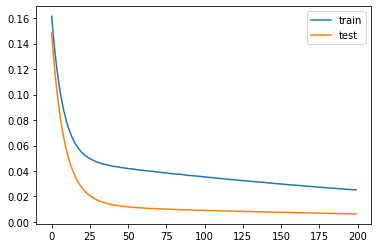

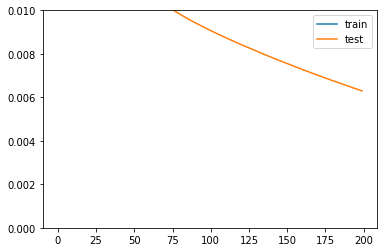

In [83]:
# plot history for loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.ylim([0,0.01])
pyplot.legend()
pyplot.show()
